# 2. Sensor fusion of Gaussian random walk
In this example notebook we consider data from a random process, a Gaussian random walk, that is collected by two different methods: a noisy sensor that measures automatically in a regular interval and manually performed measurements that are collected irregularly but with a high precision. For the setup of the inference problem, we do not know the exact precision of the sensor, but for the manually performed measurements.


## Data
The Gaussian random walk is

$$X_{t+1} = X_t + \mathcal{N}(0, 1)$$.

When generating the data, we set the sensor measurements to have a noise level of 1, but this will be unknown in the inference problem later on. The manually performed measurements are performed with a noise level of $10^{-3}$, which will be known when setting up the model. These measurements are collected at 10% of the time steps.

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore')


def rng(seed=100): return default_rng(seed)


N = 40

time = np.arange(N)

epsilon = rng().normal(0, 1, N)

latent_process = np.cumsum(epsilon)

measure_error = np.array([1e-3, 1])

timesteps = pd.date_range("2018-01-01 00:00:00", tz='utc', periods=N, freq="H")

y = (latent_process.reshape(-1, 1) + rng().normal(0, measure_error, size=(N, len(measure_error)))).T.flatten()
df = pd.DataFrame(
    {
        'time': np.tile(timesteps, len(measure_error)),
        'type': np.repeat(['manual', 'sensor'], N),
        'y': y
    })

df_0 = df.loc[df['type'] == 'sensor']
df_1 = df.loc[df['type'] == 'manual'].sample(frac=.1, random_state=rng()).sort_values(by='time')
experiment_df = pd.concat([df_0, df_1], ignore_index=True)

This results in rather long periods of time not covered by manual measurements:

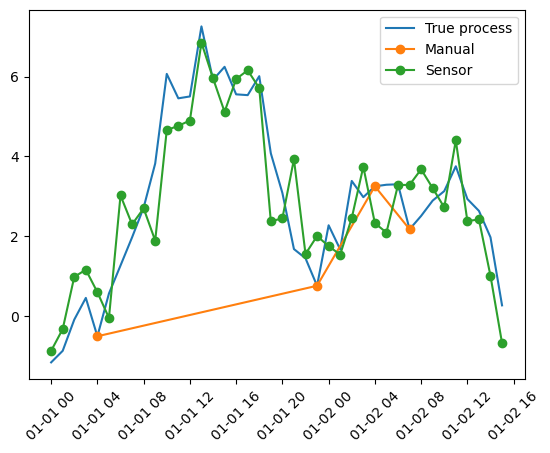

In [2]:
import matplotlib.pyplot as plt

plt.plot(timesteps, latent_process, label='True process')
for k, sub in experiment_df.groupby(by='type'):
    plt.plot(sub.time, sub['y'], '-o', label=str(k).capitalize())

plt.xticks(rotation=45)
plt.legend()
plt.show()

In this dataframe, which we will do inference on, for each observation we are given a time step and what type of measurement that was used:

In [3]:
experiment_df

,time,type,y
0,2018-01-01 00:00:00+00:00,sensor,-0.867794
1,2018-01-01 01:00:00+00:00,sensor,-0.323820
2,2018-01-01 02:00:00+00:00,sensor,0.984069
3,2018-01-01 03:00:00+00:00,sensor,1.162007
4,2018-01-01 04:00:00+00:00,sensor,0.599998
5,2018-01-01 05:00:00+00:00,sensor,-0.044833
6,2018-01-01 06:00:00+00:00,sensor,3.022350
7,2018-01-01 07:00:00+00:00,sensor,2.298663
8,2018-01-01 08:00:00+00:00,sensor,2.698330
9,2018-01-01 09:00:00+00:00,sensor,1.891397


## Model
We have the time steps $t=1, \ldots, T$, and the set of of time steps when we have performed manual measurements $M \subset \{1, \ldots, T\}$. From the data we have the vector of $\mathbf{y} \in \mathbb{R}^T$ and the vector of manual measurements $\mathbf{z} \in \mathbb{R}^{|M|}$. Our model is then

$$
X_0 = \mathcal{N}(0, 1)\\
X_{t+1} = X_t + \mathcal{N}(0, 1), \text{ for } t=1,\ldots,T-1\\
\sigma_m \sim \text{HalfNormal}(1)\\
y_t \sim \mathcal{N}(X_t, \sigma_m) \text{ for } t=1,\ldots,T-1\\
z_t \sim\mathcal{N}(X_t, 10^{-3}) \text{ for } t \in M.\\
$$

We start by creating components for the data, and for the $X$ variables, which will be stretched over the time steps:

In [10]:
import pymc as pm
from sakkara.model import data_components, DistributionComponent as DC

data = data_components(experiment_df)

X = DC(pm.GaussianRandomWalk, name='X', group='time')

Note that the dataframe contains 40 unique time steps, together with four duplicates. This is however handled by Sakkara, so that the resulting `X` variable will be 40-dimensional. One important remark is that the order of the dimensions, corresponding to the different time steps, is decided by the order of appearance of the time steps in the data frame. Since [`pm.GaussianRandomWalk`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.GaussianRandomWalk.html) creates a vector of variables that are ordered as consecutive states of the Markov chain, and since the order of the first appearance of each time step in the data frame is the same as the time steps sorted chronologically, we get the correct model.

To create component for the standard deviation, we will use **`GroupComponent`**, which a handy way to create components that are different for the different group members:

In [11]:
from sakkara.model import GroupComponent as GC

sigma_m = DC(pm.HalfNormal, name='sigma_m')

sigma = GC(name='sigma', group='type', membercomponents={'manual': 1e-3, 'sensor': sigma_m})

This formulation means that we will assign `sigma` to be either $10^{-3}$ or the random variable `sigma_m`, depending on the value of the 'type' column in the dataframe.

All that is left is creating the likelihood and building the model:

In [12]:
from sakkara.model import Likelihood, build

likelihood = Likelihood(pm.Normal, mu=X, sigma=sigma, observed=data['y'])

model = build(experiment_df, likelihood)

Note that `mu=X` will correspond to a 40-dimensional vector in PyMC, `sigma=sigma` will correspond to a two-dimensional vector in PyMC, and `data['y']` has 44 values. Sakkara will do the job of mapping each row of the observables to the right the entries of `sigma` and `X`, decided upon the values in the 'time' and 'type' columns of the data frame.

Now, inference!

In [13]:
idata = pm.sample(model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X, sigma_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


## Results
Starting with the marginal posterior for $\sigma_m$, we see a slight tendency of under-estimation. Recall that there are only four time steps when both sensor and manual measurements were performed, and therefore the prior may have a large impact.

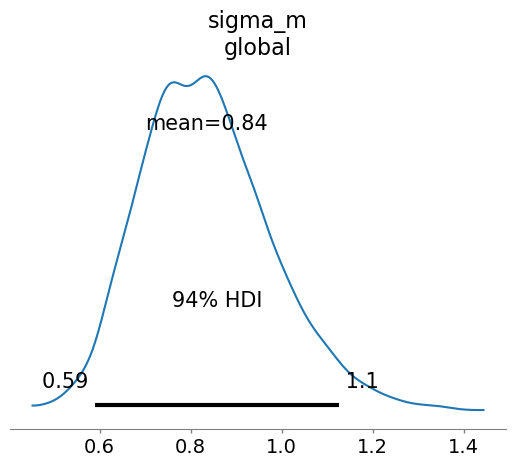

In [8]:
import arviz as az

az.plot_posterior(idata, var_names='sigma_m')
plt.show()

Considering the estimates of the Gaussian random walk $X$, we can utilize the precise manually performed measurements to get small range of the distribution around those correspinding time steps. However, we miss out on the true process value at one point, probably due to the slight under-estimation of $\sigma_m$. 

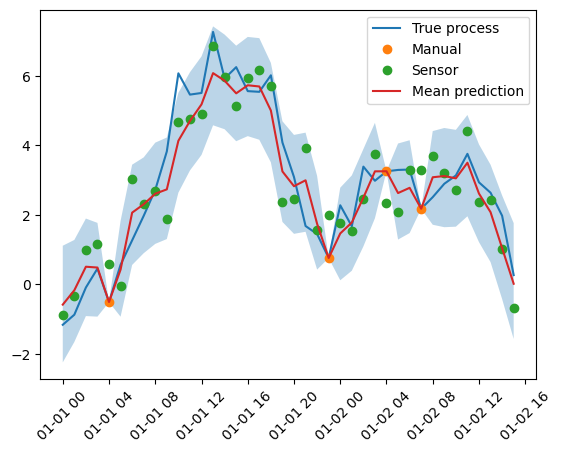

In [9]:
plt.plot(timesteps, latent_process, label='True process')
plt.plot(experiment_df.loc[experiment_df['type'] == 'manual', 'time'],
         experiment_df.loc[experiment_df['type'] == 'manual', 'y'], 'o', label='Manual')
plt.plot(experiment_df.loc[experiment_df['type'] == 'sensor', 'time'],
         experiment_df.loc[experiment_df['type'] == 'sensor', 'y'], 'o', label='Sensor')

posterior = idata.posterior['X'].to_dataframe()['X']

plt.fill_between(timesteps, posterior.groupby('time').quantile(.01).values, posterior.groupby('time').quantile(.99).values, alpha=.3)
plt.plot(timesteps, posterior.groupby('time').mean().values, label='Mean prediction')

plt.legend()
plt.xticks(rotation=45)
plt.show()